In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%cd ManTraNet_2020

/home/adek/ManTraNet_2020


In [3]:
import transforms_enhance as T
from removal import RemoveTransform
from coco_dataset_ import CopyMoveDataset, SplicingDataset
from gen_patches import DresdenDataset
from model_ASPP import create_model, model_load_weights

In [22]:
# removal dataset
rm_train_transform = RemoveTransform('../small_mask')
rm_train_dataset = DresdenDataset('../Dresden/Dresden_JPEG', 256, 256, transform=rm_train_transform)

# enhancement dataset
man_list = [T.Blur(),
            T.MorphOps(),
            T.Noise(),
            T.Quantize(),
            T.AutoContrast(),
            T.Equilize(),
            T.Compress()]
en_train_transform = T.Enhance(man_list, '../small_mask')
en_train_dataset = DresdenDataset('../Dresden/Dresden_JPEG', 256, 256, transform=en_train_transform)

json_path = "/home/adek/Desktop/instances_val2017.json"
pic_path = "/home/adek/Desktop/val2017"

# copy-move dataset
cp_train_dataset = CopyMoveDataset(json_path, pic_path, 256, 256)

# splicing dataset
sp_train_dataset = SplicingDataset(json_path, pic_path ,256, 256)

loading annotations into memory...
Done (t=0.49s)
creating index...
index created!
loading annotations into memory...
Done (t=0.53s)
creating index...
index created!


In [23]:
from torch.utils.data import DataLoader

rm_train_dataloader = DataLoader(rm_train_dataset, batch_size=2, shuffle=True)
en_train_dataloader = DataLoader(en_train_dataset, batch_size=2, shuffle=True)
cp_train_dataloader = DataLoader(cp_train_dataset, batch_size=2, shuffle=True)
sp_train_dataloader = DataLoader(sp_train_dataset, batch_size=2, shuffle=True)

In [24]:
def infinite_iter(dataloader):
    it = iter(dataloader)
    while True:
        try:
            ret = next(it)
            yield ret
        except StopIteration:
            it = iter(dataloader)

In [25]:
rm_train_iter = infinite_iter(rm_train_dataloader)
en_train_iter = infinite_iter(en_train_dataloader)
cp_train_iter = infinite_iter(cp_train_dataloader)
sp_train_iter = infinite_iter(sp_train_dataloader)

torch.Size([2, 3, 256, 256]) torch.Size([2, 1, 256, 256])


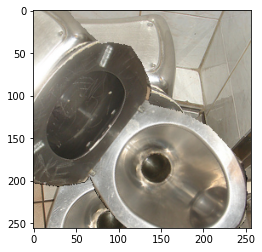

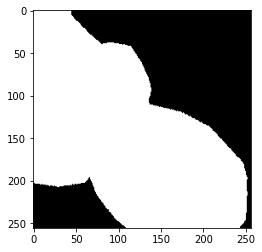

In [27]:
import matplotlib.pyplot as plt

img, mask = next(cp_train_iter)
print(img.shape, mask.shape)

plt.imshow(img[0].numpy().transpose(1, 2, 0))
plt.show()
plt.imshow(mask[0].numpy().transpose(1, 2, 0).squeeze(), cmap='gray')
plt.show()

In [21]:
img[0].shape

torch.Size([3, 256, 256])

In [9]:
def train(model, optim, num_iter, iters, criterion):
    for i in range(num_iter):
        rm_img, rm_masking = next(iters['rm'])
        en_img, en_masking = next(iters['en'])
        cp_img, cp_masking = next(iters['cp'])
        sp_img, sp_masking = next(iters['sp'])
        
        img = torch.cat([rm_img, en_img, cp_img, sp_img], dim=0)
        gt_masking = torch.cat([rm_masking, en_masking, cp_masking, sp_masking], dim=0)
        img = img.cuda()
        gt_masking = gt_masking.cuda()
        
        model.train()
        pred_masking = model(img)
        loss = criterion(pred_masking, gt_masking)
        
        optim.zero_grad()
        loss.backward()
        optim.step()
        print(i, loss.item())

In [10]:
import torch
from torch import nn
mantranet = create_model(4, True)
mantranet = model_load_weights('pretrained_weights/ManTraNet_Ptrain4.h5', mantranet)
optim = torch.optim.Adam(mantranet.parameters())
criterion = nn.BCELoss()
iters = {'rm': rm_train_iter,
         'en': en_train_iter,
         'cp': cp_train_iter,
         'sp': sp_train_iter,}
train(mantranet, optim, 20, iters, criterion)

INFO: freeze feature extraction part, trainable=False
0 0.6170942187309265
1 0.5444731712341309
There arn't any segmentation info
2 0.44816556572914124
There arn't any segmentation info
3 0.37185537815093994
4 0.3763106167316437
5 0.2726094126701355
6 0.25418609380722046
7 0.27601397037506104
8 0.194697767496109
9 0.19702033698558807
10 0.2043789029121399
11 0.21924811601638794
There arn't any segmentation info
There arn't any segmentation info
12 0.27661311626434326
13 0.29206714034080505
There arn't any segmentation info
14 0.2210446000099182
There arn't any segmentation info
15 0.27953213453292847
16 0.18538755178451538
There arn't any segmentation info
17 0.16733670234680176
18 0.20936086773872375
19 0.18020659685134888
